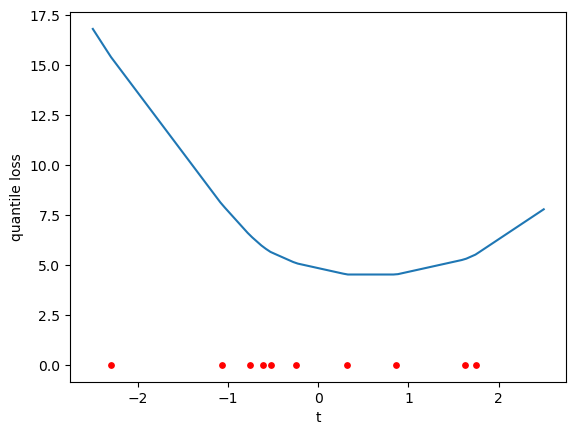

In [6]:
## plot quantile loss

import numpy as np
import matplotlib.pyplot as plt

n = 10

np.random.seed(1)

Y = np.random.randn(n)
#Y = np.random.laplace(0, 1, n)
#Y = np.random.beta(3, 5, n)

def quantile_loss(t, alpha):
    return sum( [max(alpha * (Yi - t), (alpha - 1) * (Yi - t)) for Yi in Y] )
    ## return np.sum( np.fmax(alpha * (Y - t), (alpha - 1) * (Y - t)) )

grid = np.linspace(-2.5, 2.5, 100)
alpha = 0.7

plt.plot(grid, [quantile_loss(t, alpha) for t in grid])
plt.xlabel('grid')
plt.scatter(Y, [0]*n, c='r', s=15)
plt.ylabel('quantile loss')
plt.show()

In [ ]:
## load housing data

import pandas as pd
import numpy as np

house = pd.read_csv("rainier_valley_house.csv")

house = house.sample(frac=1).reset_index(drop=True)

features = [
    "floors",
    "grade",
    "condition",
    "view",
    "sqft_living",
    "sqft_lot",
    "sqft_basement",
    "yr_built",
    "yr_renovated",
    "bedrooms",
    "bathrooms",
    "lat",
    "long"
]

Y = np.array(house['price']/1000)
X = np.array(house[features])

print(X.shape)


In [ ]:
## demo of quantile regression

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import QuantileRegressor  

mean_X = np.mean(X, axis=0)
sd_X = np.std(X, axis=0)
X_stan = (X - mean_X) / sd_X
## scaler = StandardScaler()
## X_stan = scaler.fit_transform(X)

## X_stan = np.c_[X_stan, np.ones(X_stan.shape[0])]

alpha_lo = 0.1
alpha_hi = 0.9

qr_obj1 = QuantileRegressor(quantile=alpha_lo, alpha=0, solver="highs")
qr_obj1.fit(X_stan, Y)

print(qr_obj1.coef_)

qr_obj2 = QuantileRegressor(quantile=alpha_hi, alpha=0, solver="highs")
qr_obj2.fit(X_stan, Y)


for j in range(len(features)):
    print(f"{features[j]:<15} {qr_obj1.coef_[j]:<10.2f} {qr_obj2.coef_[j]:<10.2f}")



In [ ]:
## cross validation

nfold = 5

n_total = 500

ix_mat = np.arange(n_total).reshape(nfold, -1)

coverages = [0] * nfold

for i in range(nfold):
    test_ixs = ix_mat[i, :]
    
    X_test = X_stan[test_ixs, :]
    Y_test = Y[test_ixs]
    
    train_ixs = [j for j in range(n_total) if j not in test_ixs]
    
    X_train = X_stan[train_ixs, :]
    Y_train = Y[train_ixs]
    
    qr_obj1 = QuantileRegressor(quantile=alpha_lo, alpha=0, solver="highs")
    qr_obj1.fit(X_train, Y_train)
    
    pred_quant = qr_obj1.predict(X_test)
    
    coverages[i] = np.mean((Y_test >= pred_quant))
    
print(f"CV coverage: {np.mean(coverages):<.2f}")